train acc, test acc | 0.130083, 0.137900
train acc, test acc | 0.950000, 0.948800
train acc, test acc | 0.959767, 0.958500
train acc, test acc | 0.964633, 0.962200
train acc, test acc | 0.970633, 0.964700
train acc, test acc | 0.973200, 0.964200
train acc, test acc | 0.974833, 0.966600
train acc, test acc | 0.975317, 0.968800
train acc, test acc | 0.976600, 0.970000
train acc, test acc | 0.978300, 0.969400
train acc, test acc | 0.979017, 0.969200
train acc, test acc | 0.980017, 0.971700
train acc, test acc | 0.981850, 0.971300
train acc, test acc | 0.980683, 0.972100
train acc, test acc | 0.982600, 0.971800
train acc, test acc | 0.982117, 0.971700
train acc, test acc | 0.983783, 0.974700


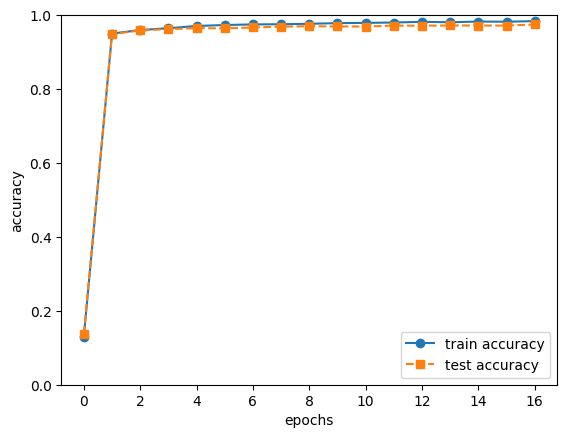

In [29]:
import sys
import os
import numpy as np
from collections import OrderedDict
sys.path.append(os.pardir)  # 상위 디렉토리의 파일을 가져올 수 있도록 설정
from dataset.mnist import load_mnist
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.layers import Affine, Relu, SoftmaxWithLoss, BatchNormalization, Dropout
from common.optimizer import Adam

class MultiLayerNet:
    def __init__(self, input_size, hidden_sizes, output_size, weight_init_std='he', use_batchnorm=True, dropout_ratio=0.2):
        self.use_batchnorm = use_batchnorm
        self.params = {}
        self.layers = OrderedDict()
        self.dropout_ratio = dropout_ratio
        
        # 모든 계층을 초기화하는 루프
        layer_sizes = [input_size] + hidden_sizes + [output_size]
        for i in range(len(layer_sizes) - 1):
            scale = None
            if weight_init_std == 'he':
                scale = np.sqrt(2.0 / layer_sizes[i])
            elif weight_init_std == 'xavier':
                scale = np.sqrt(1.0 / layer_sizes[i])
            else:
                scale = weight_init_std
            
            self.params[f'W{i+1}'] = scale * np.random.randn(layer_sizes[i], layer_sizes[i+1])
            self.params[f'b{i+1}'] = np.zeros(layer_sizes[i+1])
            self.layers[f'Affine{i+1}'] = Affine(self.params[f'W{i+1}'], self.params[f'b{i+1}'])
            
            if self.use_batchnorm:
                self.params[f'gamma{i+1}'] = np.ones(layer_sizes[i+1])
                self.params[f'beta{i+1}'] = np.zeros(layer_sizes[i+1])
                self.layers[f'BatchNorm{i+1}'] = BatchNormalization(self.params[f'gamma{i+1}'], self.params[f'beta{i+1}'])
            
            if i < len(layer_sizes) - 2:  # 마지막 Affine 계층 전까지 Relu 및 드롭아웃 계층 추가
                self.layers[f'Relu{i+1}'] = Relu()
                self.layers[f'Dropout{i+1}'] = Dropout(self.dropout_ratio)
        
        self.lastLayer = SoftmaxWithLoss()  # 출력 계층

    def predict(self, x, train_flg=False):
        for key, layer in self.layers.items():
            if 'Dropout' in key or 'BatchNorm' in key:
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x, train_flg=True)
        return self.lastLayer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x, train_flg=False)
        y = np.argmax(y, axis=1)
        if t.ndim != 1:
            t = np.argmax(t, axis=1)
        return np.sum(y == t) / float(x.shape[0])

    def gradient(self, x, t):
        # 순전파
        self.loss(x, t)
        
        # 역전파
        dout = 1
        dout = self.lastLayer.backward(dout)
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        affine_idx = 1  # Affine 계층의 인덱스 추적
        for key, layer in self.layers.items():
            if isinstance(layer, Affine):  # Affine 계층에서만 기울기 저장
                grads[f'W{affine_idx}'] = layer.dW
                grads[f'b{affine_idx}'] = layer.db
                affine_idx += 1
            if isinstance(layer, BatchNormalization):
                grads[f'gamma{affine_idx-1}'] = layer.dgamma
                grads[f'beta{affine_idx-1}'] = layer.dbeta
        return grads

if __name__ == '__main__':
    # 데이터 읽기
    (x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
    
    # 네트워크 생성
    network = MultiLayerNet(input_size=784, hidden_sizes=[50, 50, 50, 50], output_size=10, weight_init_std='he', use_batchnorm=True, dropout_ratio=0.2)
    
    iters_num = 10000
    train_size = x_train.shape[0]
    batch_size = 100
    learning_rate = 0.01  # 초기 학습률
    
    optimizer = Adam(lr=learning_rate)
    
    train_loss_list = []
    train_acc_list = []
    test_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    
    for i in range(iters_num):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
        
        grad = network.gradient(x_batch, t_batch)
        optimizer.update(network.params, grad)
        
        loss = network.loss(x_batch, t_batch)
        train_loss_list.append(loss)
        
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            test_acc = network.accuracy(x_test, t_test)
            train_acc_list.append(train_acc)
            test_acc_list.append(test_acc)
            print(f"train acc, test acc | {train_acc:.6f}, {test_acc:.6f}")
            
            # 학습률 스케줄링: 학습률 감소
            if learning_rate > 0.0001:
                learning_rate *= 0.99
                optimizer.lr = learning_rate
    
    # 학습 결과 시각화
    markers = {'train': 'o', 'test': 's'}
    x = np.arange(len(train_acc_list))
    plt.plot(x, train_acc_list, label='train accuracy', marker='o')
    plt.plot(x, test_acc_list, label='test accuracy', marker='s', linestyle='--')
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.ylim(0, 1.0)
    plt.legend(loc='lower right')
    plt.show()